In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER
import datetime
import seaborn as sns
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from stock_env import StockTradingEnv
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
from pprint import pprint
import scienceplots
import sys
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
sys.path.append("../FinRL-Library")
import quantstats as qs
plt.style.use('science')
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - time_window - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  # more descriptive condition for early termination to clarify the logic
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            # print(len(date_list))
            # print(len(asset_list))
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
            account_memory = df_account_value
            actions_memory = df_actions
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory,test_obs
DATA_START_DATE = '1999-01-01'
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
from pandas import read_csv
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent


In [2]:

df_dow = YahooDownloader(start_date = DATA_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()
# df_nasdaq = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = NAS_100_TICKER).fetch_data()
# df_hsi = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = HSI_50_TICKER).fetch_data()
# df_dax = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = DAX_30_TICKER).fetch_data()

# df_sp500 = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = SP_500_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (185454, 8)


In [7]:
df_dow.to_csv('./data/dow.csv')
df_nasdaq.to_csv('./data/nasdaq.csv')
df_hsi.to_csv('./data/hsi.csv')
df_dax.to_csv('./data/dax.csv')
df_sp500.to_csv('./data/sp500.csv')

In [ ]:
# df_dow =read_csv('./data/dow.csv')
# df_nasdaq =read_csv('./data/nasdaq.csv')
# df_hsi = read_csv('./data/hsi.csv')
# df_dax = read_csv('./data/dax.csv')
# df_sp500 = read_csv('./data/sp500.csv')

In [3]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dow)
processed_dax = processed_dax.copy()
processed_dax = processed_dax.fillna(0)
processed_dax = processed_dax.replace(np.inf,0)
train_data = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)


Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features


In [116]:
def train(train_data,test_data,INDICATORS,model_name,model_parameters,iterations,save = True,load_model = False,tag=''):
    stock_dimension = len(train_data.tic.unique())
    state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
    buy_cost_list = sell_cost_list = [0.001] * stock_dimension
    num_stock_shares = [0] * stock_dimension

    env_kwargs = {
        "hmax": 100,
        "initial_amount": 1000000,
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_list,
        "sell_cost_pct": sell_cost_list,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "turbulence_threshold" : 70
    }


    train_environment = StockTradingEnv(df = train_data, **env_kwargs)
    test_environment = StockTradingEnv(df = test_data, **env_kwargs)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name
                                    ,model_kwargs = model_parameters)
    if not load_model:
        model = agent.train_model(model=model_agent, 
                                    tb_log_name=model_name,
                                    total_timesteps=iterations)
    else:
      print('loading model')
      model = model_agent.load('./data/'+str(model_name)+'_'+str(iterations)+'_' +tag ,env =train_environment)
    if save and not load_model:
        model.save('./data/'+str(model_name)+'_'+str(iterations)+'_' +tag )
    predictions = DRLAgent.DRL_prediction(model, test_environment)
    predictions[0].date = pd.to_datetime(predictions[0].date )
    return {
            'name': model_name,
            'account':predictions[0],
            'actions':predictions[1],
            'state':test_environment.state_memory,
            }


state shape is account value + prices + current holding of stocks +   + indocators values for each stock

# Todo : change reward function

In [ ]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0003,
    "batch_size": 128,
}

ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",PPO_PARAMS,100_000,False,load_model=True)
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,100_000,False,load_model=True)
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,100_000,False,load_model=True)
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,100_000,False,load_model=True)
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,100_000,False,load_model=True)



In [ ]:
states = np.array(td3_predictions['state'])
states_prices = states[:,1:len(train_data.tic.unique())+1]
states_shares = states[:,len(train_data.tic.unique())+1 : 2*len(train_data.tic.unique())+1  ]

In [103]:
holdigns = states_shares* states_prices
holdings = pd.DataFrame(holdigns,columns=train_data.tic.unique())


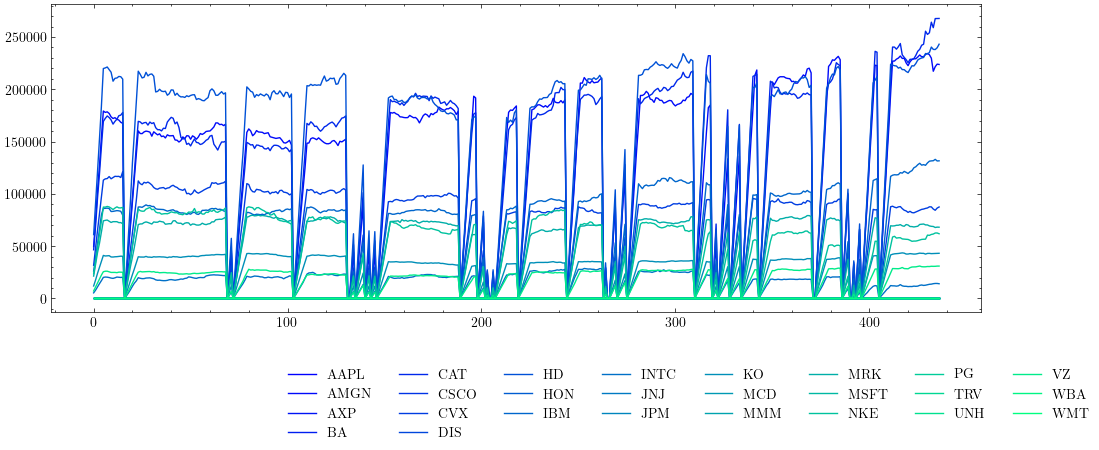

In [105]:
%matplotlib inline
with plt.style.context('science','ieee'):
    holdings.plot(figsize=(12,4),colormap="winter",).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

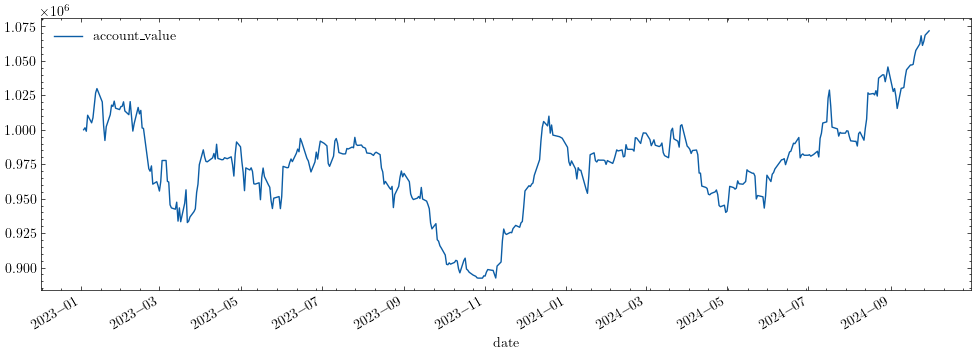

In [77]:
%matplotlib inline
with plt.style.context('science','ieee'):

    td3_predictions[0][0].plot(x='date',y='account_value',figsize=(12,4))


In [ ]:
from utils import baseline


results = baseline(processed_dax, INDICATORS, TEST_START_DATE, TEST_END_DATE)

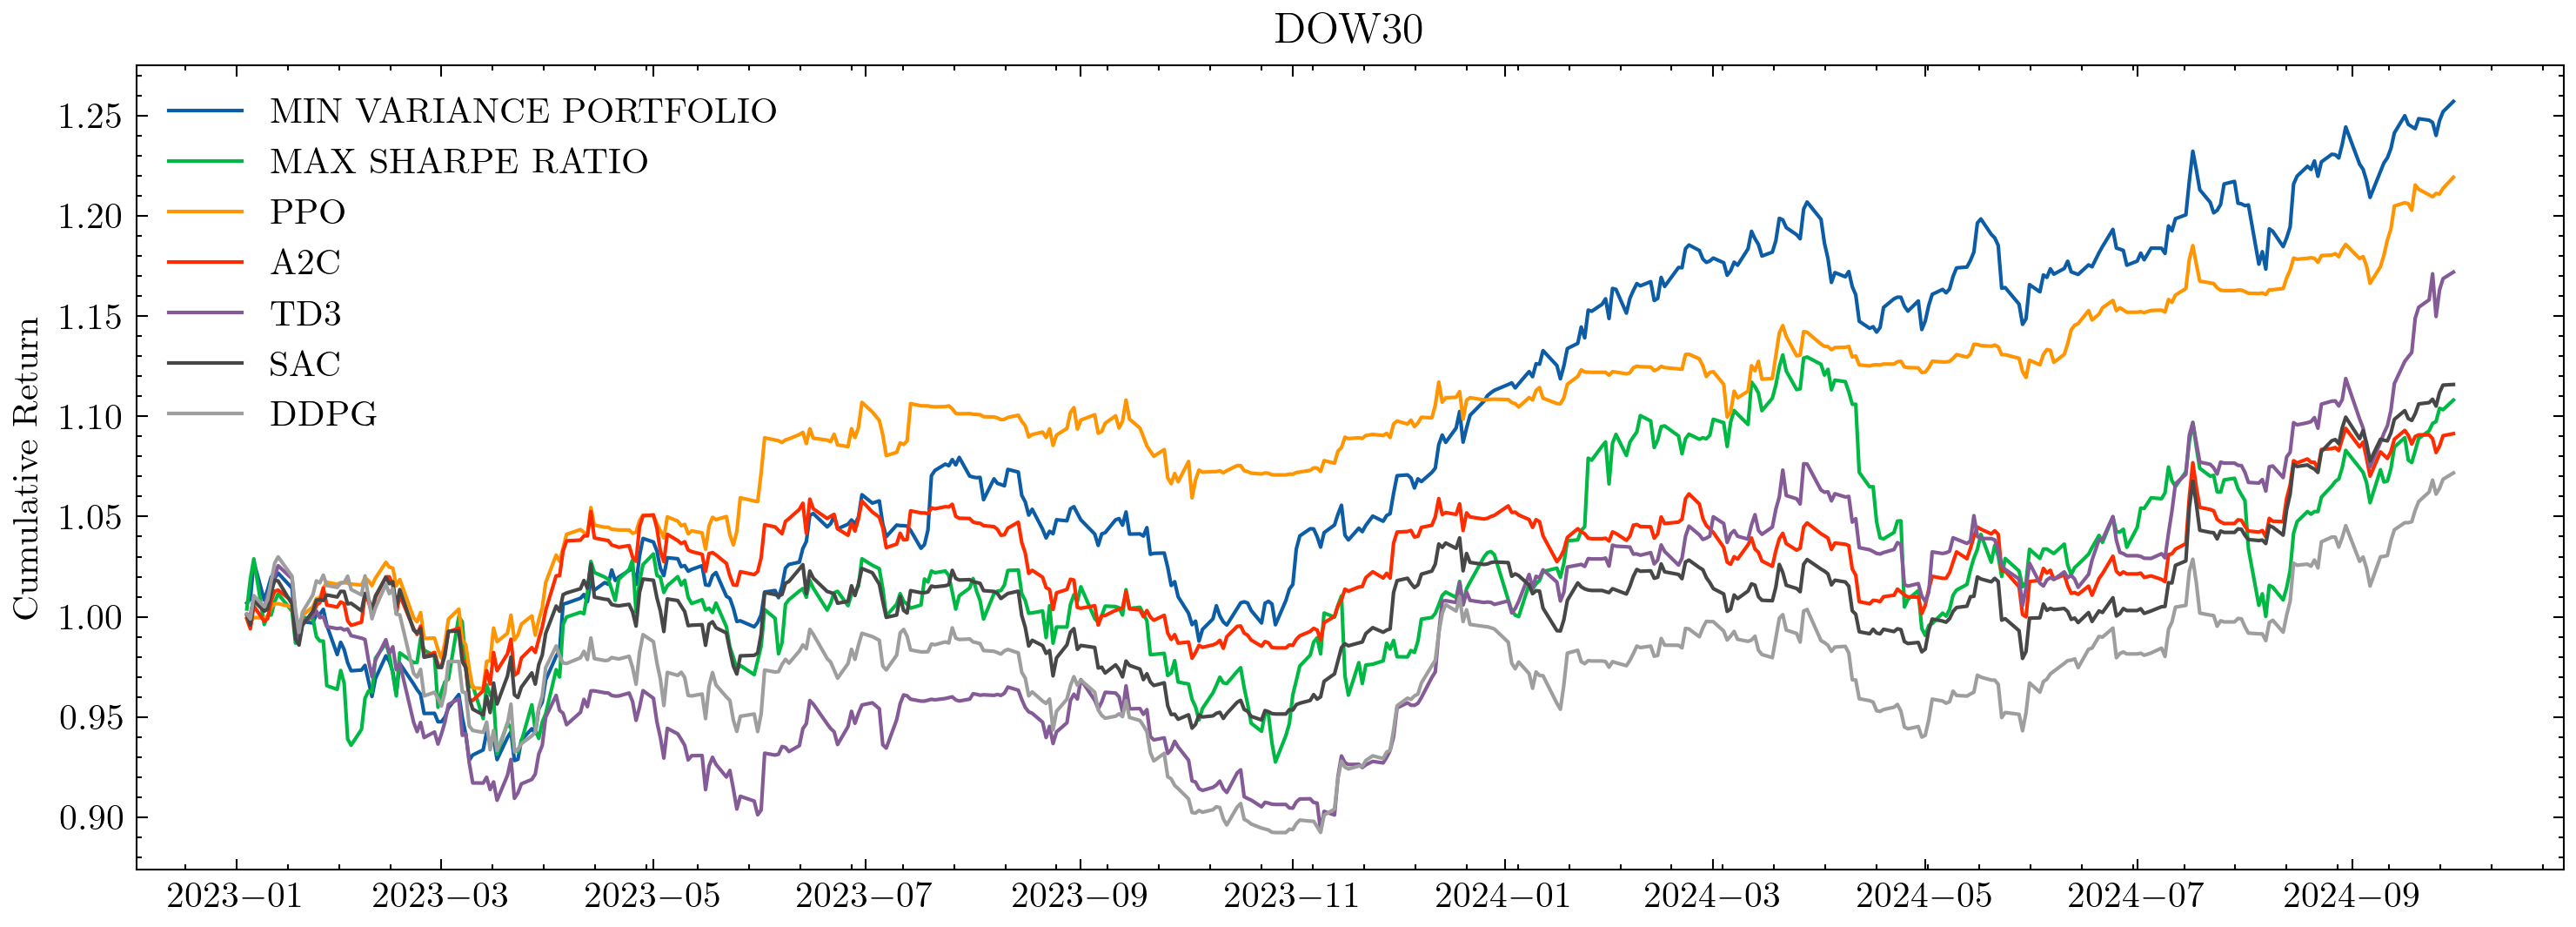

In [111]:



with plt.style.context('science','ieee'):
    
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(results):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.plot(ppo_predictions['account']['date'],(ppo_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='PPO')
    plt.plot(a2c_predictions['account']['date'],(a2c_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='A2C')
    plt.plot(td3_predictions['account']['date'],(td3_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='TD3')
    plt.plot(sac_predictions['account']['date'],(sac_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='SAC')
    plt.plot(ddpg_predictions['account']['date'],(ddpg_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='DDPG')

    plt.legend()
    
    plt.ylabel('Cumulative Return')
    plt.title('DOW30')
    plt.show()

In [114]:
DATA_START_DATE = '1999-01-01'
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2006-12-30'
TEST_START_DATE = '2007-01-01'
TEST_END_DATE = '2008-12-31'

train_data = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)


In [117]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0003,
    "batch_size": 128,
}

ppo_predictions = train(train_data,test_data,INDICATORS,"ppo",PPO_PARAMS,100_001,tag='recession')
a2c_predictions = train(train_data,test_data,INDICATORS,"a2c",None,100_001,tag='recession')
td3_predictions = train(train_data,test_data,INDICATORS,"td3",None,100_001,tag='recession')
sac_predictions = train(train_data,test_data,INDICATORS,"sac",None,100_001,tag='recession')
ddpg_predictions = train(train_data,test_data,INDICATORS,"ddpg",None,100_001,tag='recession')



Stock Dimension: 26, State Space: 79
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 1.76e+03   |
|    ep_rew_mean     | -6.78      |
| time/              |            |
|    fps             | 115        |
|    iterations      | 1          |
|    time_elapsed    | 17         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.26828608 |
-----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.76e+03      |
|    ep_rew_mean          | -8            |
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 2             |
|    time_elapsed         | 36            |
|   

In [119]:
results = baseline(processed_dax, INDICATORS, TEST_START_DATE, TEST_END_DATE)

begin_total_asset:50000
end_total_asset:45397.853830802545
Sharpe:  -0.07122663024319065
Test Finished!
episode_return 0.907957076616051
begin_total_asset:1000000
end_total_asset:937659.021342952
Sharpe:  -0.004584509538979365
Test Finished!
episode_return 0.9376590213429521
begin_total_asset:1000000
end_total_asset:937659.021342952
Sharpe:  -0.004584509538979365
Test Finished!
episode_return 0.9376590213429521


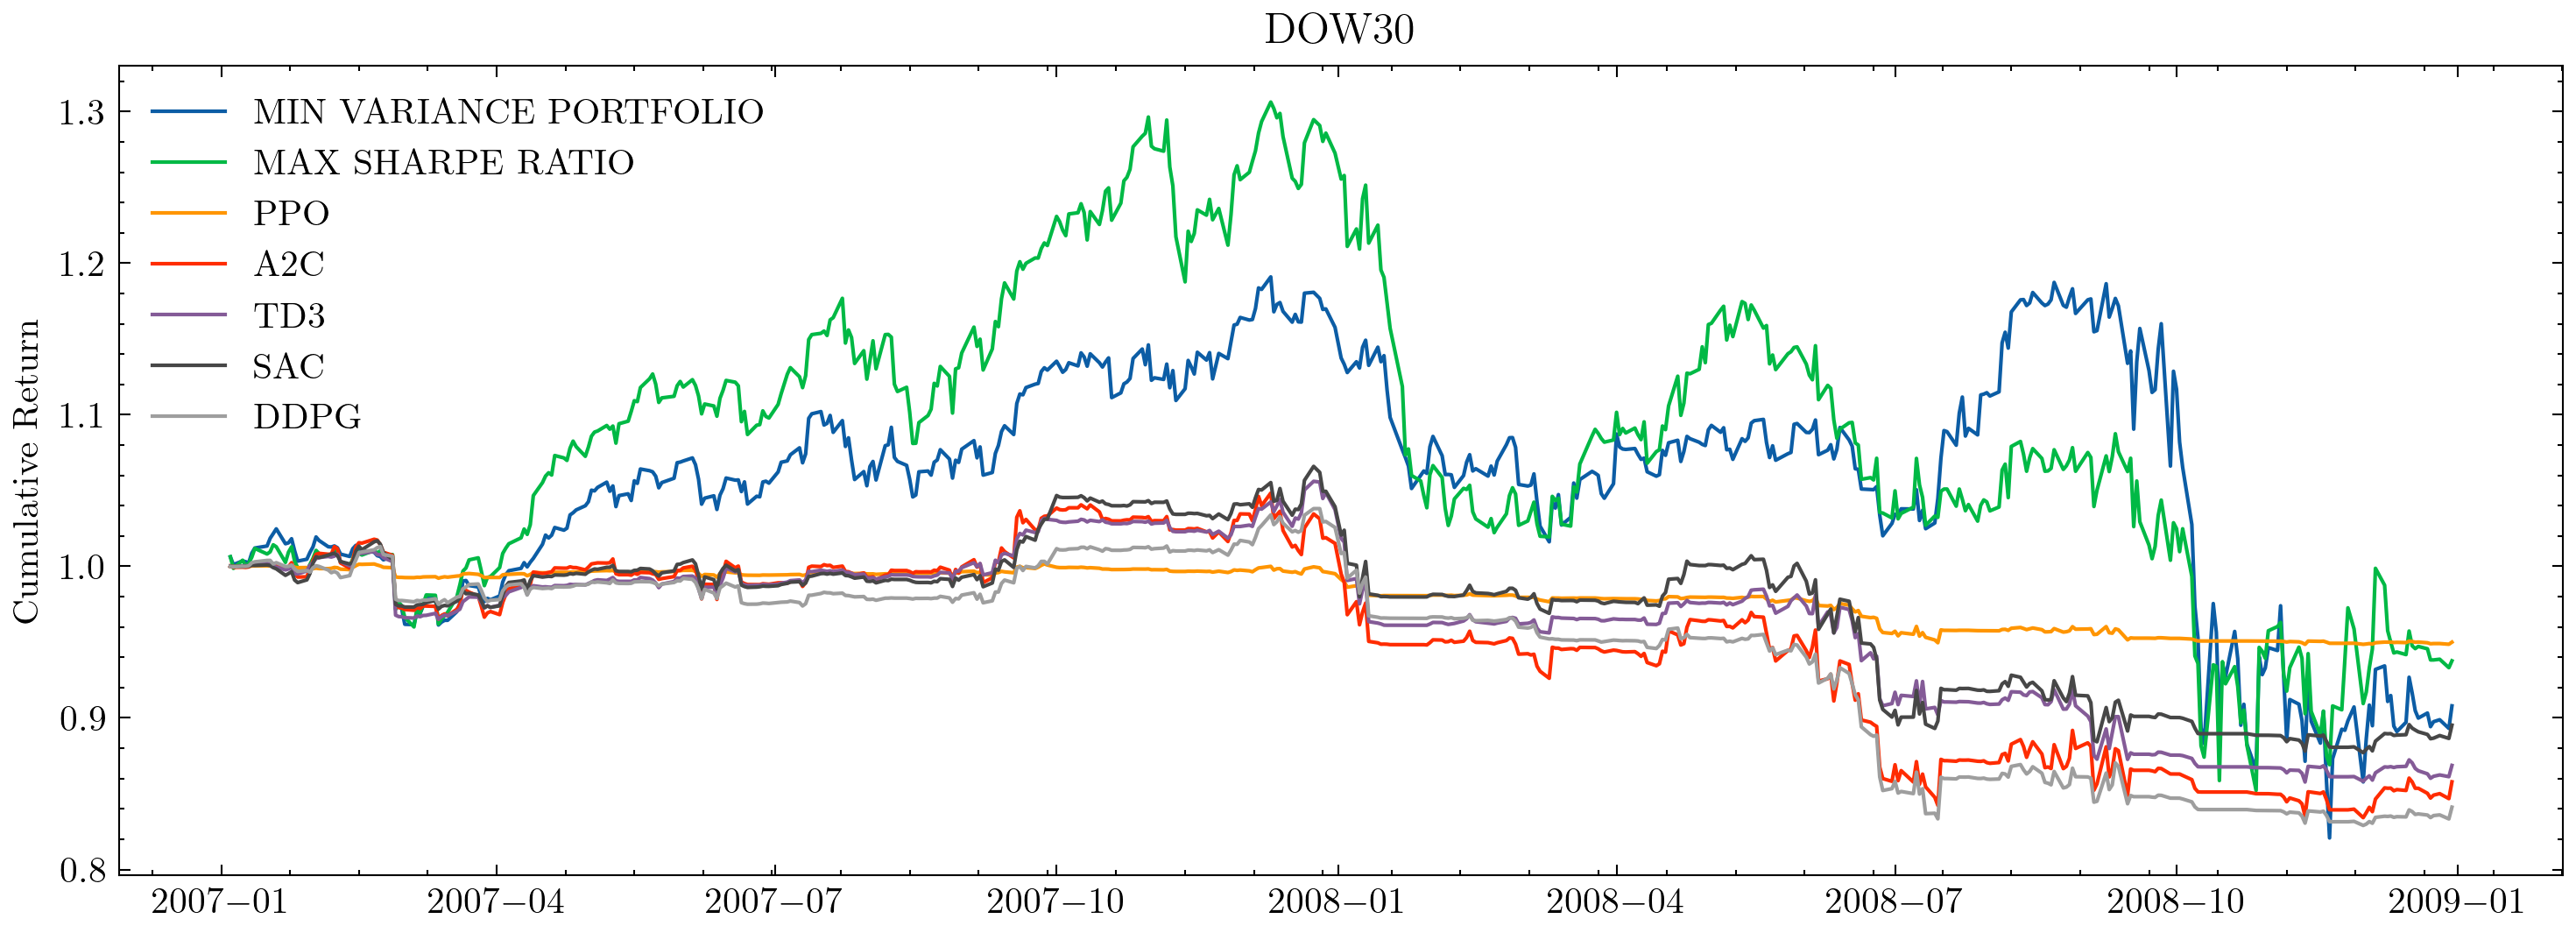

In [121]:
with plt.style.context('science','ieee'):
    
    plt.figure(figsize=(12,4),dpi=300)
    for i,item in enumerate(results):
        plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.plot(ppo_predictions['account']['date'],(ppo_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='PPO')
    plt.plot(a2c_predictions['account']['date'],(a2c_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='A2C')
    plt.plot(td3_predictions['account']['date'],(td3_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='TD3')
    plt.plot(sac_predictions['account']['date'],(sac_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='SAC')
    plt.plot(ddpg_predictions['account']['date'],(ddpg_predictions['account']['account_value'].pct_change()+ 1 ).cumprod(),label='DDPG')

    plt.legend()
    
    plt.ylabel('Cumulative Return')
    plt.title('DOW30')
    plt.show()